# Packages

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import random

import simpy

In [2]:
ε = 0.00001

def isZero(x):
    return abs(x)<ε

# Entities

In [3]:
# Time tolerance: when at current speed difference a crash might occur within that number of seconds
CRITICAL_TIME_TOLERANCE = 4  # [s] 


## Lanes

In [4]:
def normaliseDirection(d):
    d = d.lower()
    if d=='r' or d=='fast':
        return 'fast'
    elif d=='l' or d=='slow':
        return 'slow'
    else:
        return None

In [5]:
LANE_ID = 0

class Lane:
    
    ## some additional code
    def __init__(self, length, speedLimit):
        
        global LANE_ID
        self.id = LANE_ID
        LANE_ID += 1
        
        self.length = length
        self.speedLimit = speedLimit
        self.vehicles = []
        
        self.next = None
        self.prev = None
        
        # lane attached to the left/right
        self.left = None
        self.right = None
      
    # defines generic str() method for Lanes
    # extends the method with list of vehicles on the lane
    def __str__(self):
        l = "" if self.left is None else f" L:{self.left.id:d}"
        r = "" if self.right is None else f" R:{self.right.id:d}"
        vs = "" if len(self.vehicles)==0 else " "
        for v in self.vehicles:
            vs += str(v)
        return f"[{self.id:d} {int(self.length):d}m"+l+r+vs+"]" + \
                    ("-" + str(self.next) if self.next is not None else "")
    
    def getLane(self, direction):
        if direction=='slow':
            return self.left
        elif direction=='fast':
            return self.right
        else:
            return None

    # adding parallel lane on right side
    def attachRight(self, lane):
        self.right = lane
        lane.left = self
 
    # adding parallel lane on right side
    def attachLeft(self, lane):
        self.left = lane
        lane.right = self
     
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenRight(self):
        lane = self
        newLane = Lane(lane.length, lane.speedLimit)
        lane.attachRight(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(lane.length, lane.speedLimit)
            lane.attachRight(newLane)
            newLane.prev = lane.prev.right
            newLane.prev.next = newLane
        return self.right
            
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenLeft(self):
        lane = self
        newLane = Lane(lane.length, lane.speedLimit)
        lane.attachLeft(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(lane.length, lane.speedLimit)
            lane.attachLeft(newLane)
            newLane.prev = lane.prev.left
            newLane.prev.next = newLane
        return self.left
        
    # defines concatenation of lanes
    def extend(self, lane):
        l = self
        while l.next is not None:
            l = l.next
        l.next = lane
        lane.prev = l
        return self
    
    def totalLength(self):
        total = self.length
        l = self
        while l.next is not None:
            l = l.next
            total += l.length
        return total
    
    ## additional code
    ## new generalised access method needed to calculate sideway view
    ## returns all vehicles between pos+distFrom and pos+distTo
    def at(self, pos, distFrom=0, distTo=0):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
                # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        res = []
        for v in self.vehicles:
            if pos+distFrom < v.pos and v.pos < pos+distTo:
                res.append(v)
        # if the required distance reaches over the end of the lane segment
        if pos+distTo > self.length and self.next is not None:
            res = res + self.next.at(0, distFrom=0, distTo=distTo-(self.length-pos))
        if pos+distFrom < 0 and self.prev is not None:
            res = self.prev.at(self.prev.length, distFrom=pos+distFrom, distTo=0) + res
        return res
        
    def inFront(self, pos, far=0):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        for v in self.vehicles:
            if v.pos > pos:
                return v if v.pos-pos<far else None
        # there is none in front in this lance
        # if the free lane in front is long enough or there is no next lane
        if self.length-pos>far or self.next is None:
            return None
        else:
            return self.next.inFront(0, far=far-(self.length-pos))
        
    def behind(self, pos, far=0):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # This time we sort in reverse order
        self.vehicles.sort(key=lambda v: v.pos, reverse=True)
        for v in self.vehicles:
            if v.pos < pos:
                return v if pos-v.pos<far else None
        # there is none behind in this lance
        # if the free lane in behind is long enough or there is no previous lane
        if pos>far or self.prev is None:
            return None
        else:
            return self.prev.behind(self.prev.length, far=far-pos)
        
    def enter(self, vehicle, pos=0):
        self.vehicles.insert(0, vehicle)
        vehicle.pos = pos
        vehicle.lane = self
        vehicle.rec.record(vehicle, event="enter lane")

    def leave(self, vehicle):
        vehicle.rec.record(vehicle, event="leave lane")
        vehicle.lane = None
        # in the meantime the vehicle may have have moved
        # to one of the next lane segments...
        lane = self
        while lane is not None:
            if vehicle in lane.vehicles:
                lane.vehicles.remove(vehicle)
                break
            else:
                lane = lane.next

## Vehicles

In [6]:
def isRunning(p):
    return p is not None and p.running

def isCrashed(p):
    return p is not None and p.crashed

In [7]:
VEHICLE_ID = 0

class Vehicle:
    def __init__(self, env, rec, 
                 startingLane=None, startingPos=0,
                 t0=0, x0=0, dx0=0, ddx0=0, dddx0=0, 
                 t=[], v=[],
                Min_Time_Diff=1,Min_Speed_Test = 2,Car_Lenght = 4,
                 Far_Away_In_Front = 200,Far_Away_In_Back = 80,
                Lane_Change_time=3,a_min=-4,a_max=2.5):
        
        global VEHICLE_ID
        self.id = VEHICLE_ID
        VEHICLE_ID += 1
        
        
        self.Lane_Change_time = Lane_Change_time # [s]
        self.a_min = a_min # [m/s²]
        self.a_max = a_max # [m/s²] corresponds to 0-100km/h om 12s
        self.Min_Time_Diff = Min_Time_Diff
        self.Min_Speed_Test = Min_Speed_Test # [m/s] min speed diff to trigger overtaking
        self.Car_Lenght = Car_Lenght # [m]
        self.Far_Away_In_Front = Far_Away_In_Front # [m]  distance at which a car in front can be ignored
        self.Far_Away_In_Back = Far_Away_In_Back   # [m]  distance at which a car behind can be ignored
        
        self.env = env
        self.rec = rec
            
        self.startingLane = startingLane
        self.startingPos = startingPos
        self.lane = None
        self.pos = 0
        
        ## second lane reference during changing of lanes
        self.oldLane = None
            
        self.t0 = t0
        self.x0 = x0
        self.dx0 = dx0
        self.ddx0 = ddx0
        self.dddx0 = dddx0
        
        self.t = t
        self.v = v
        self.t_target = []
        self.v_target = []
        
        self.running = False
        self.crashed = False
        self.braking = False
        self.changingLane = False
        
        self.processRef = None
        self.env.process(self.process())
        
        ## this allows to trigger trace messages for
        ## the new feature Surround
        self.traceSurround = False
        self.traceOvertake = False
        self.traceBrake = False
    
    def __str__(self):
        return f"({self.id:d})"         
    
    def isNotFasterThan(self, other):
        return True if other is None else self.dx0 <= other.dx0
    
    def isNotSlowerThan(self, other):
        return True if other is None else other.dx0 <= self.dx0
    
    def updateOnly(self):
        if self.crashed:
            return False
        t = self.env.now
        if t < self.t0:
            return False
        if self.running and t > self.t0:
            dt = t - self.t0
            ddx = self.ddx0 + self.dddx0*dt
            dx = round(self.dx0 + self.ddx0*dt + self.dddx0*dt*dt/2,4)
            Δx = self.dx0*dt + self.ddx0*dt*dt/2 + self.dddx0*dt*dt*dt/6
            x = round(self.x0 + Δx, 2)
            self.t0, self.x0, self.dx0, self.ddx0 = t, x, dx, ddx
            
            self.pos = round(self.pos+Δx, 2)
            # update lane information if necessary
            if self.pos >= self.lane.length:
                nextPos = self.pos - self.lane.length
                nextLane = self.lane.next
                self.lane.leave(self)
                if nextLane is None:
                    self.rec.record(self, event='end')
                    self.running = False
                    return False
                else:
                    nextLane.enter(self, pos=nextPos)
        return True
        
    def update(self):
        active = self.updateOnly()
        if not active:
            return False
        
        self.surround = Surround(self)
        
        ## instead of direct link, call method
        inFront = self.surround.front
        if (isRunning(inFront) or isCrashed(inFront)) \
               and inFront.x0 < self.x0 + self.Car_Lenght:
            self.crash(inFront)
            return True

        if inFront is not None and not self.braking and \
                self.dx0 > inFront.dx0 and \
                self.x0 + CRITICAL_TIME_TOLERANCE*self.dx0 > inFront.x0:
            Δt = max(self.Min_Time_Diff, (inFront.x0-self.x0)/self.dx0)
            self.setTarget(Δt, inFront.dx0)
            self.interruptProcess()
            return True
        
        ## new code: start overtaking maneuver by changing into fast lane
        if inFront is not None and \
                not self.braking and not self.changingLane and \
                self.dx0 > inFront.dx0 + self.Min_Speed_Test and \
                self.x0 + (self.Lane_Change_time+CRITICAL_TIME_TOLERANCE)*self.dx0 > inFront.x0 and \
                self.surround.rightLane is not None and \
                self.surround.right is None and \
                self.isNotFasterThan(self.surround.rightFront) and \
                self.isNotSlowerThan(self.surround.rightBack):
            if self.traceOvertake:
                print(f"t={self.t0:7,.1f}s Overtaking v{self.id:d} overtakes v{inFront.id:d} at x={self.x0:7,.1f}m")
            self.setTarget(self.Lane_Change_time, 'fast')
            self.interruptProcess()
            return True
            
        ## new code: end overtaking by returning to slow lane
        if self.surround.leftLane is not None and \
                not self.braking and not self.changingLane and \
                self.surround.left is None and \
                self.isNotFasterThan(self.surround.leftFront) and \
                self.surround.leftBack is None:
            if self.traceOvertake:
                print(f"t={self.t0:7,.1f}s Overtaking v{self.id:d} returns to slow lane at x={self.x0:7,.1f}m")
            self.setTarget(self.Lane_Change_time, 'slow')
            self.interruptProcess()
            return True
     
    def setTarget(self, Δt, v):
        self.t_target = [ Δt ] + self.t_target
        self.v_target = [ v ] + self.v_target
      
    def process(self):

        # delay start to the given time t-
        if self.t0>self.env.now:
            yield self.env.timeout(self.t0-self.env.now)
        self.t0 = env.now
        self.running = True
        self.rec.startRecording(self)
        self.startingLane.enter(self, pos=self.startingPos)
        
        while self.running:
            self.updateOnly()
            
            self.surround = Surround(self)

            inFront = self.surround.front
            if inFront is not None:
                
                # if the car in front is slower and we are a bit too near on its heals...
                if inFront.dx0 < self.dx0 and \
                        inFront.x0 < self.x0 + CRITICAL_TIME_TOLERANCE*self.dx0:
                    if self.traceBrake:
                        print(f"t={self.t0:7,.1f}s Braking v{self.id:d} v={self.dx0:4.4f}m/s to {inFront.dx0:4.4f}")


                    yield from self.emergencyBraking(inFront.dx0)
                    if not isZero(self.dx0-inFront.dx0):
                        # after emergency breaking adjust to the speed of the car in front...
                        Δt = 2
                        self.setTarget(Δt, inFront.dx0)
                    continue 
        
            if len(self.t_target)==0:
                self.t_target = self.t.copy()
                self.v_target = self.v.copy()
                
            if len(self.t_target)>0:
                
                ## add code for explicit change of lane
                if type(self.v_target[0]) is str:
                    direction = normaliseDirection(self.v_target[0])
                    t = self.t_target[0]
                    self.t_target = self.t_target[1:]
                    self.v_target = self.v_target[1:]  
                    if self.lane.getLane(direction) is not None:
                        yield from self.changeLane(direction, t)
                
                ## the rest is what was there before
                else:
                    v0 = self.dx0
                    v1 = self.v_target[0]
                    t = self.t_target[0]
                    self.t_target = self.t_target[1:]
                    self.v_target = self.v_target[1:]  
                    if isZero(v1-v0):
                        yield from self.wait(t)
                    else:
                        yield from self.adjustVelocity(v1-v0, t)
            else:
                yield from self.wait(10)
        
        self.rec.stopRecording(self)
  
    def emergencyBraking(self, v):
        
        def emergencyBrakingProcess(v):
            self.rec.record(self, 'brake')
            minΔt = 0.2
            self.dddx0 = (self.a_min-self.ddx0)/minΔt      
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0=0
            self.ddx0=self.a_min
            v = min(v, self.dx0-2)
                # the brake time estimate is for perfect timing for 
                # autonomous cars. For manual driving leave out the
                # -minΔt/2 or use a random element.
            Δt = max(0.5, (v-self.dx0)/self.ddx0 - minΔt/2)
            yield self.env.timeout(Δt)
                
            self.updateOnly()
            self.dddx0 = -self.ddx0/minΔt      
            yield self.env.timeout(minΔt)
      
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0

        
        ## The 'braking' bit prevents the interruption of an emergency breaking process 
        self.braking = True
        self.processRef = self.env.process(emergencyBrakingProcess(v))
        try:
            yield self.processRef
        except simpy.Interrupt:
            pass
        self.processRef = None
        self.braking = False
 
    ## make changeLane robust against interrupt:
    def changeLane(self, direction, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def changeLaneProcess(oldLane, newlane, Δt):
            self.updateOnly()
            self.rec.record(self, 'change '+direction)
            self.oldLane = oldLane
            newLane.enter(self, pos=self.pos) 
            self.ddx0 = 1
            self.dddx0 = 0
            yield self.env.timeout(Δt)
            self.oldLane.leave(self)
            self.lane = newLane
            self.oldLane = None
            self.rec.record(self, 'done change '+direction)
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0
        
        ## keep record of current lane, as in case of aborting
        ## the lane change 
        ## when interrupted go back into original lane
        oldLane = self.lane
        newLane = self.lane.getLane(direction)
        self.changingLane = True
        try:
            self.processRef = self.env.process(changeLaneProcess(oldLane, newLane, Δt))
            yield self.processRef
            self.processRef = None
        except simpy.Interrupt:
            # if interrupted go quickly back into old lane
            # but this is not interruptible
            self.processRef = None
            self.env.process(changeLaneProcess(newLane, oldLane, Δt/4))
        self.changingLane = False

    def adjustVelocity(self, Δv, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def adjustVelocityProcess():
            self.updateOnly()
            minΔt = 0.1*Δt
            a = Δv/(Δt-minΔt)
            tt = Δt-2*minΔt
            
            self.dddx0 = (a-self.ddx0)/minΔt     
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = a
            yield self.env.timeout(tt)
            
            self.updateOnly()
            self.dddx0 = -a/minΔt
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = 0
        
        self.processRef = self.env.process(adjustVelocityProcess())
        try:
            yield self.processRef
        except simpy.Interrupt:
            self.dddx0 = 0
            pass
        self.processRef = None

    def wait(self, Δt):
         
        def waitProcess():
            yield self.env.timeout(Δt) 
        
        self.processRef = self.env.process(waitProcess())
        try:
            yield self.processRef
        except simpy.Interrupt:
            pass
        self.processRef = None

    def interruptProcess(self):
        if self.processRef is not None and self.processRef.is_alive:
            self.processRef.interrupt('change')
            
    def crash(self, other):
        
        def recordCrash(self):
            self.rec.record(self, 'crash')
            self.running = False
            self.crashed = True
            self.dx0 = 0
            self.ddx0 = 0
            self.dddx0 = 0
            
        if self.running:
            print(f"Crash p{self.id:d} into p{other.id:d} at t={self.t0:7.3f} x={self.x0:7.1f}")
            recordCrash(self)
            if other.running:
                recordCrash(other)       

In [8]:
class Surround:
    
    def __init__(self, vehicle):
        
        def s(vehicle):
            if vehicle is None:
                return " "
            elif type(vehicle) is list:
                if len(vehicle)==1:
                    return s(vehicle[0])
                else:
                    res = "["
                    for v in vehicle:
                        if len(res)>1:
                            res += ','
                        res+=s(v)
                    res += "]"
                    return res
            else:
                return f"{vehicle.id:d}"
        
        # For each of the directions None means that there is no 
        # vehicle in the immediate vicinity.
        # We initialise to a 'safe' value which can be easily detected
        # if something goes wrong
        
        self.leftBack = vehicle
        self.left = vehicle
        self.leftFront = vehicle
        self.back = vehicle
        self.vehicle = vehicle
        self.front = vehicle
        self.rightBack = vehicle
        self.right = vehicle
        self.rightFront = vehicle
        
        lane = vehicle.lane
        pos = vehicle.pos
        if lane is not None:
            self.lane = lane
            self.front = lane.inFront(pos,vehicle.Far_Away_In_Front)
            self.back = lane.behind(pos,vehicle.Far_Away_In_Back)
            
            self.rightLane = lane.right
            if self.rightLane is not None:
                if vehicle.oldLane == lane.right:
                    # drifting left
                    self.right = vehicle
                    self.rightFront = self.rightLane.inFront(pos,vehicle.Far_Away_In_Front)
                    self.rightBack = self.rightLane.behind(pos,vehicle.Far_Away_In_Back)
                else:
                    right = self.rightLane.at(pos,-vehicle.Car_Lenght/2,vehicle.Car_Lenght/2)
                    if len(right)==0:
                        self.right = None
                    elif len(right)==1:
                        self.right = right[0]
                    else:
                        self.right = right

                    if self.right is None:
                        self.rightFront = self.rightLane.inFront(pos,vehicle.Far_Away_In_Front)
                        self.rightBack = self.rightLane.behind(pos,vehicle.Far_Away_In_Back)
                    else:
                        self.rightFront = None
                        self.rightBack = None
                
            self.leftLane = lane.left
            if self.leftLane is not None:
                if vehicle.oldLane == lane.left:
                    # drifting right
                    self.left = vehicle
                    self.leftFront = self.leftLane.inFront(pos,vehicle.Far_Away_In_Front)
                    self.leftBack = self.leftLane.behind(pos,vehicle.Far_Away_In_Back)
                else:
                    left = self.leftLane.at(pos,-vehicle.Car_Lenght/2,vehicle.Car_Lenght/2)
                    if len(left)==0:
                        self.left = None
                    elif len(left)==1:
                        self.left = left[0]
                    else:
                        self.left = left
                        
                    if self.left is None:
                        self.leftFront = self.leftLane.inFront(pos,vehicle.Far_Away_In_Front)
                        self.leftBack = self.leftLane.behind(pos,vehicle.Far_Away_In_Back)
                    else:
                        self.leftFront = None
                        self.lefttBack = None
                    
        if vehicle.traceSurround:
            print(f"surround t={self.vehicle.env.now:6.2f} " +
                  "|" +
                  ("" if self.leftLane is None else 
                      f"|{s(self.leftBack):s}>{s(self.left):s}>{s(self.leftFront):s}") +
                  f"|{s(self.back):s}>{s(self.vehicle):s}>{s(self.front):s}|" +
                  ("" if self.rightLane is None else
                      f"{s(self.rightBack):s}>{s(self.right):s}>{s(self.rightFront):s}|") +
                  "|"
                 )

# Recorder

In [9]:
class SimpleRecorder:
    
    def __init__(self, env, startTime, stopTime, timeStep):
        
        global VEHICLE_ID, LANE_ID
        VEHICLE_ID = 0
        LANE_ID = 0
        
        self.env = env
        self.startTime = startTime
        self.stopTime = stopTime
        self.timeStep = timeStep
        self.vehiclesToTrace = []
        self.vehicles = []
        self.data = pd.DataFrame(columns=['t', 'x', 'v', 'a', 'id', 'lane', 'oldLane', 'pos', 'event'])

    # runs the simulation
    def run(self):       
        self.env.process(self.process())
        self.env.run(self.stopTime+self.timeStep)
        
    def startRecording(self, p):
        self.vehicles.append(p)
        
    def stopRecording(self, p):
        self.vehicles.remove(p)
        
    def record(self, p=None, event='timer'):
        if p is not None:
            if p.updateOnly():
                laneId = None if p.lane is None else p.lane.id
                oldLaneId = None if p.oldLane is None else p.oldLane.id
                if p.running or event!='timer':
                    ix = len(self.data)
                    self.data.loc[ix]=[self.env.now, p.x0, p.dx0, p.ddx0, p.id, laneId, oldLaneId, p.pos, event] 
                    if event=='timer':
                        p.update()            
        else:
            for p in self.vehicles:
                self.record(p)
        
    def getData(self):
        return self.data.copy(deep=True)
    
    def getEvents(self):
        return self.data[self.data.event!='timer'].copy(deep=True)

    def process(self):
        yield self.env.timeout(self.startTime-self.env.now)
        while self.env.now <= self.stopTime:
            self.record()
            yield self.env.timeout(self.timeStep)
            
    def plot(self, x, y, 
             vehicles=None, 
             xmin=None, xmax=None, ymin=None, ymax=None):
        columns = ['t', 'x', 'v', 'a']
        labels = ['Time [s]', 'Position [m]', 'Velocity [m/s]', 'Acceleration [m/s²]']
        xindex = columns.index(x)
        yindex = columns.index(y)
        
        plt.figure(figsize=(6, 4), dpi=120)
        if xmin is not None and xmax is not None:
            plt.xlim((xmin, xmax))
        if ymin is not None and ymax is not None:
            plt.ylim((ymin, ymax))
        
        if vehicles is None:
            vehicles = list(self.data.id.unique())
        for id in vehicles:
            df = self.data[self.data.id==id]
            plt.plot(x, y, '', data=df)
            plt.xlabel(labels[xindex])
            plt.ylabel(labels[yindex])
            
            # use small circle to indicate emergency braking
            db = df[df.event=='brake']
            for i in range(len(db)):
                X = db.iloc[i, xindex]
                Y = db.iloc[i, yindex]
                plt.plot([X], [Y], 'ro')

            # use black 'x' as crash indicator
            dc = df[df.event=='crash']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'xk')
            
            # use black right pointing triangle
            # to indicate that a vehicle 
            # was changing into the fast lane
            dc = df[df.event=='change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '>k')
                
            # use black left pointing triangle
            # to indicate that a vehicle 
            # was changing into the slow lane
            dc = df[df.event=='done change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '<k')
                
            # use black diamond to indicate that
            # a vehicle ran out of track
            dc = df[df.event=='end']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'Dk')
                
        plt.grid(True)

In [10]:
#def randomIntervals(cycles, length=100):
#    return [ max(0, random.normalvariate(length, length/3)) for i in range(cycles) ]
def randomSpeedVariation_1(vmax, cycles, cv=0.02):
    return [ vmax + (-1)**i*abs(random.normalvariate(0, vmax*cv)) for i in range(cycles) ]

In [11]:
SLOW_CYCLE=100
def randomIntervals(cycles):
    # return [ random.expovariate(1.0/SLOW_CYCLE)+10 for i in range(cycles) ] 
    return [ max(0, random.normalvariate(SLOW_CYCLE, SLOW_CYCLE/3)) for i in range(cycles) ]
#SPEED_VARIATION = 0.05
#def randomSpeedVariation(vmax, cycles):
#    return [ vmax + (-1)**i*abs(random.normalvariate(0, vmax*SPEED_VARIATION)) for i in range(cycles) ] 

In [12]:
#SLOW_CYCLE=100
#def randomIntervals(cycles):
#    return [ random.expovariate(1.0/SLOW_CYCLE)+10 for i in range(cycles) ] 
#    #return [ max(0, random.normalvariate(SLOW_CYCLE, SLOW_CYCLE/3)) for i in range(cycles) ] 

In [13]:
random.seed(20)

In [14]:
def random_speed(free_speed,quantiles):
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(quantiles)):
        if u<quantiles[i+1]:
            p = (u-quantiles[i])/(quantiles[i+1]-quantiles[i])
            return free_speed[i]*p+free_speed[i+1]*(1-p)


def freeMotorwaySpeed(free_speed,quantiles):
    speeds = [ random_speed(free_speed,quantiles) for i in range(1200)]
    kernel = stats.gaussian_kde(speeds)

    vel = np.arange(30, 191)
    q = [ kernel.integrate_box_1d(30, i) for i in vel ]
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(q)):
        if u<q[i+1]:
            p = (u-q[i])/(q[i+1]-q[i])
            # return (free_speed[i+1]+free_speed[i])/2*p+(1-p)*(free_speed[i+1]+free_speed[i+2])/2
            return vel[i]*p+vel[i+1]*(1-p)
def randomSpeedVariation(vmax, cycles,free_speed,quantiles):
    return [math.floor(freeMotorwaySpeed(free_speed,quantiles)/3.6) for i in range(cycles)]

In [15]:
VMAX = 120/3.6
IAT=10
CYCLES = random.randint(4, 8)
#iat = [ random.uniform(IAT/10,IAT+10) for i in range(200) ]
iat=[ random.expovariate(1.0/IAT) for i in range(10) ]
iat

[3.0087194089698515,
 10.098485893089766,
 23.533069156129997,
 20.567440815540532,
 8.50832327511783,
 1.8558056615126446,
 5.3021754088476944,
 50.893559523783985,
 1.0897570917011172,
 3.8439732388604746]

In [53]:
VMAX = 120/3.6
N = 50 # number of points
IAT = 30 # time difference between start
random.seed(13)
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1500, 1)
#iat = [ random.expovariate(1.0/IAT) for i in range(N) ]
iat = [ random.uniform(IAT-4,IAT-6) for i in range(N) ]

LANE_ID = 0
l = Lane(2000, VMAX)
r = l.widenRight()
ll=l.widenLeft()
l.extend(Lane(1000, VMAX))
rr=r = l.widenRight()
r = l.widenRight()
print("left Lane: ", ll)
print("centr Lane: ", l)
print("Right Lane:", r)

t0=0
for i in range(N):
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation_1(VMAX, CYCLES)
    t0=i*iat[i]
    v=Vehicle(env, rec, startingLane=l, t0=t0, dx0=speed[-1], t=times, v=speed)
    v.traceOvertake=True
rec.run()

left Lane:  [2 2000m R:0]
centr Lane:  [0 2000m L:2 R:6]-[3 1000m R:7]
Right Lane: [6 2000m L:0]-[7 1000m L:3]
t=    0.0s Overtaking v0 returns to slow lane at x=    0.0m
t=   25.0s Overtaking v1 returns to slow lane at x=   12.5m
t=   50.0s Overtaking v2 returns to slow lane at x=   24.3m
t=   73.0s Overtaking v3 returns to slow lane at x=    3.1m
t=  103.0s Overtaking v4 returns to slow lane at x=   15.7m
t=  128.0s Overtaking v5 returns to slow lane at x=   10.0m
t=  155.0s Overtaking v6 returns to slow lane at x=   25.2m
t=  179.0s Overtaking v7 returns to slow lane at x=    5.0m
t=  197.0s Overtaking v8 returns to slow lane at x=   25.1m
t=  232.0s Overtaking v9 returns to slow lane at x=   11.3m
t=  250.0s Overtaking v10 returns to slow lane at x=   20.8m
t=  282.0s Overtaking v11 returns to slow lane at x=   23.9m
t=  305.0s Overtaking v12 returns to slow lane at x=    2.4m
t=  327.0s Overtaking v13 returns to slow lane at x=    7.4m
t=  341.0s Overtaking v14 returns to slow lan

In [54]:
randomSpeedVariation_1(VMAX, CYCLES)
print(speed)

[33.65681275185505, 32.25989001197571, 33.579943693584745, 32.78739810032938, 33.42486294997936, 32.69204147538265]


In [55]:
randomIntervals(CYCLES)
print(times)

[141.70558028524465, 77.99114212312837, 111.79781247163538, 118.11546836024027, 69.14440147727251, 136.45763372491726]


In [56]:
data = rec.getData()
id_0 = data[data.id==39]

In [57]:
data = rec.getData()
data

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,33.112566,0,0,0,None,0,enter lane
1,0,0,33.112566,0,0,0,None,0,timer
2,0,0,33.112566,0,0,0,None,0,change slow
3,0,0,33.112566,0,0,2,0,0,enter lane
4,1,33.61,34.112600,1,0,2,0,33.61,timer
...,...,...,...,...,...,...,...,...,...
3225,1284,1902.72,33.339900,-0.048896,49,2,None,1902.72,timer
3226,1285,1936.04,33.291000,-0.048896,49,2,None,1936.04,timer
3227,1286,1969.31,33.242100,-0.048896,49,2,None,1969.31,timer
3228,1287,2002.53,33.193200,-0.048896,49,2,None,2002.53,leave lane


In [58]:
rec.getEvents()

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,33.112566,0,0,0,None,0,enter lane
2,0,0,33.112566,0,0,0,None,0,change slow
3,0,0,33.112566,0,0,2,0,0,enter lane
6,3,103.83,36.112600,1,0,2,0,103.83,leave lane
7,3,103.83,36.112600,1,0,2,None,103.83,done change slow
...,...,...,...,...,...,...,...,...,...
3128,1235,2012.07,33.690600,-0.0468289,46,None,None,2012.07,end
3219,1280,2011.31,34.815300,-0.0363275,48,2,None,2011.31,leave lane
3220,1280,2011.31,34.815300,-0.0363275,48,None,None,2011.31,end
3228,1287,2002.53,33.193200,-0.048896,49,2,None,2002.53,leave lane


In [59]:
id_0.groupby(id_0['event']).nunique()

,t,x,v,a,id,lane,oldLane,pos,event
event,,,,,,,,,
change slow,1,1,1,1,1,1,0,1,1
done change slow,1,1,1,1,1,1,0,1,1
end,1,1,1,1,1,0,0,1,1
enter lane,2,2,2,2,1,2,1,2,1
leave lane,2,2,2,2,1,1,1,2,1
timer,55,55,55,15,1,2,1,55,1


In [60]:
ent_lane=id_0[id_0['event']=="enter lane"]
ent_lane

,t,x,v,a,id,lane,oldLane,pos,event
2516,960.108,0,34.188837,0,39,0,None,0,enter lane
2521,961,30.5,34.188700,-0.000383147,39,2,0,30.5,enter lane


In [61]:
ent_lane.iloc[0]['t']

960.1080332176876

In [62]:
lev_lane=id_0[id_0['event']=="leave lane"]
lev_lane

,t,x,v,a,id,lane,oldLane,pos,event
2528,964,137.57,37.1887,1,39,2,0,137.57,leave lane
2631,1016,2020.01,34.9741,-0.0480496,39,2,None,2020.01,leave lane


In [63]:
lev_lane.iloc[-1]['t']

1016

In [116]:
data = rec.getData()
id_car=data.id.unique()
#diff_time=[]
end_time=[]
for car in id_car:
    car_data=data[data.id==car]
    start_lane_1=car_data[car_data['event']=="enter lane"]
    end_lane_1=car_data[car_data['event']=="end"]
    if(len(end_lane_1.index)!=0):
        end_time.append(end_lane_1.iloc[-1]['t']-start_lane_1.iloc[0]['t'])
average_travelling_time=sum(end_time)/len(end_time)
average_travelling_time

66.68488973153885

In [118]:
average_travelling_time*1.2

80.02186767784661

In [113]:
end_time

[57,
 56.370515985929075,
 56.73632767206444,
 58.09601696833958,
 59.48579339098988,
 57.30558608965468,
 56.76591901802101,
 57.152281097869576,
 57.74437763540436,
 58.16538409949547,
 56.62629503694038,
 56.70596567081827,
 57.0717620903207,
 58.221088538197534,
 57.45438229409234,
 58.25206443622858,
 56.26183657478691,
 56.37845303393135,
 59.10881970954068,
 61.281571589844134,
 57.389584448442406,
 54.85396719741004,
 56.360074966005186,
 56.25850702890159,
 54.56752400619041,
 57.68852753826036,
 57.89670669017369,
 57.34881477429224,
 57.25998760984453,
 56.79022337408924,
 57.84831591610077,
 57.633814063557566,
 57.308968014063566,
 57.36826987676727,
 55.835772876122974,
 57.01434232902977,
 57.11520354016545,
 59.071139148623274,
 56.91177010521017,
 55.89196678231235,
 57.338108665459686,
 58.36974229623877,
 56.206654598486466,
 55.327715940713006,
 58.019196027263206,
 57.897037285549004,
 56.10618601616193,
 57.641650144054665,
 56.31792857964933,
 58.02698431650333]

# Throughput

In [67]:
#THROUGHPUT
l=len(rec.getData()[data.event=="end"])
FirstE=rec.getData()[data.event=="end"].iloc[0]['t']
LastE=rec.getData()[data.event=="end"].iloc[-1]['t']
l/((LastE-FirstE)/3600)

146.34146341463415

# AVERAGE TRAVELING TIME

In [119]:
#AVERAGE TRAVELLING TIME
average_travelling_time=sum(end_time)/len(end_time)
average_travelling_time

66.68488973153885

In [71]:
def optimum_throughput(T_opt, t):
    t2 = []
    new_att = 1.2*T_opt
    for j in range(len(t)):
        if t[j] >= new_att:
            t2.append(t[j])
        else:
            break
    return t2 

In [73]:
#t22=optimum_throughput(avg,end_time)
#ttt=sum(t22)/len(t22)
#ttt= ttt/3600

In [74]:
#N/ttt

# Position vs Time Graph

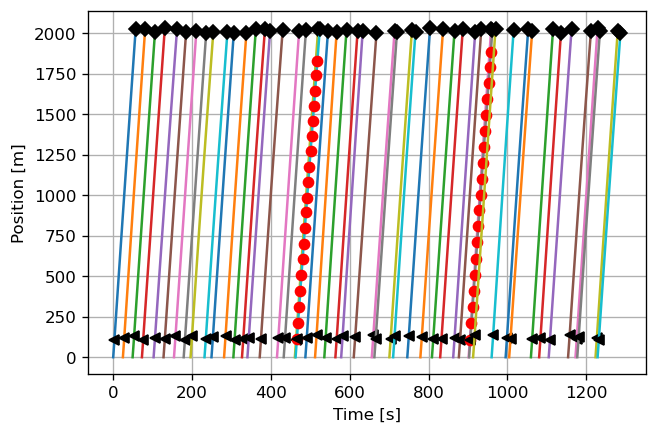

In [69]:
rec.plot('t','x')

# Time vs Velocity

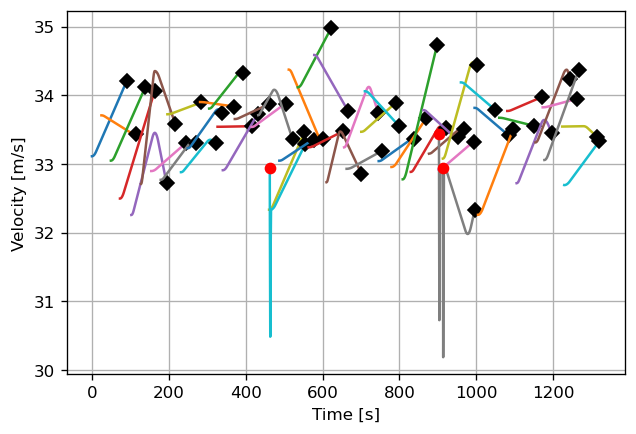

In [34]:
rec.plot('t', 'v')

# Simulation for Multiple Type of Vehicles 

In [35]:
Vehicles=["familycar","electriccar","rigid_truck","articulated_vehicle","bus"]

In [36]:
class Vehicles:
    def __init__(self,startingLane=None, startingPos=0,
                 t0=0, x0=0, dx0=0, ddx0=0, dddx0=0, 
                 t=[], v=[],
                Min_Time_Diff=1,Min_Speed_Test = 2,Car_Lenght = 4,
                 Far_Away_In_Front = 200,Far_Away_In_Back= 80,
                Lane_Change_time=3,a_min=-4,a_max=2.5,free_speed=[],quantiles=np.cumsum([])):
        
              
        self.Lane_Change_time = Lane_Change_time # [s]
        self.a_min = a_min # [m/s²]
        self.a_max = a_max # [m/s²] corresponds to 0-100km/h om 12s
        self.Min_Time_Diff = Min_Time_Diff
        self.Min_Speed_Test = Min_Speed_Test # [m/s] min speed diff to trigger overtaking
        self.Car_Lenght = Car_Lenght # [m]
        self.Far_Away_In_Front = Far_Away_In_Front # [m]  distance at which a car in front can be ignored
        self.Far_Away_In_Back = Far_Away_In_Back   # [m]  distance at which a car behind can be ignored
        self.startingLane = startingLane
        self.free_speed=free_speed
        self.quantiles=quantiles


# Family Car     


In [76]:
Lane_Change_time = 4# [s]
a_min = -4 # [m/s²]
a_max = 2.5 # [m/s²] corresponds to 0-100km/h om 12s
Min_Time_Diff = 1
Min_Speed_Test = 4 # [m/s] min speed diff to trigger overtaking
Car_Lenght = 4 # [m]
Far_Away_In_Front = 200 # [m]  distance at which a car in front can be ignored
Far_Away_In_Back = 80
free_speed = [ 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170 ]
quantiles = np.cumsum([0, 0.003, 0.014, 0.052, 0.148, 0.27, 0.309, 0.143, 0.048, 0.01, 0.003])
startingLane = l


familycar=Vehicles(Lane_Change_time=Lane_Change_time,a_min=a_min,Min_Time_Diff=Min_Time_Diff,Min_Speed_Test=Min_Speed_Test
                  ,Car_Lenght=Car_Lenght,Far_Away_In_Front=Far_Away_In_Front,Far_Away_In_Back=Far_Away_In_Back,startingLane=startingLane,
                  free_speed=free_speed,quantiles=quantiles)

# Electric Car

In [77]:
Lane_Change_time = 3 # [s]
a_min = -4 # [m/s²]
a_max = 2.5 # [m/s²] corresponds to 0-100km/h om 12s
Min_Time_Diff = 1
Min_Speed_Test = 3 # [m/s] min speed diff to trigger overtaking
Car_Lenght = 4 # [m]
Far_Away_In_Front = 150 # [m]  distance at which a car in front can be ignored
Far_Away_In_Back = 60
free_speed = [ 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170 ]
quantiles = np.cumsum([0, 0.003, 0.025, 0.059, 0.226, 0.275, 0.409, 0.243, 0.148, 0.010, 0.003])
startingLane = l


electriccar=Vehicles(Lane_Change_time=Lane_Change_time,a_min=a_min,Min_Time_Diff=Min_Time_Diff,Min_Speed_Test=Min_Speed_Test
                  ,Car_Lenght=Car_Lenght,Far_Away_In_Front=Far_Away_In_Front,Far_Away_In_Back=Far_Away_In_Back,startingLane=startingLane,
                  free_speed=free_speed,quantiles=quantiles)

# Rigid Truck

In [78]:
Lane_Change_time = 7 # [s]
a_min = -4 # [m/s²]
a_max = 2.5 # [m/s²] corresponds to 0-100km/h om 12s
Min_Time_Diff = 1
Min_Speed_Test = 8 # [m/s] min speed diff to trigger overtaking
Car_Lenght = 15 # [m]
Far_Away_In_Front = 250 # [m]  distance at which a car in front can be ignored
Far_Away_In_Back = 100
#Quantiles has been changed according to RSA graph for rigid trucks on motorways
free_speed = [ 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170 ]
quantiles = np.cumsum([0, 0.008, 0.118, 0.711, 0.108, 0.027, 0.022, 0.19, 0.015, 0.010, 0.003])
startingLane = l


rigid_truck=Vehicles(Lane_Change_time=Lane_Change_time,a_min=a_min,Min_Time_Diff=Min_Time_Diff,Min_Speed_Test=Min_Speed_Test
                  ,Car_Lenght=Car_Lenght,Far_Away_In_Front=Far_Away_In_Front,Far_Away_In_Back=Far_Away_In_Back,startingLane=startingLane,
                  free_speed=free_speed,quantiles=quantiles)

# Articulated Vehicles

In [79]:
Lane_Change_time = 10 # [s]
a_min = -4 # [m/s²]
a_max = 2.5 # [m/s²] corresponds to 0-100km/h om 12s
Min_Time_Diff = 1
Min_Speed_Test = 10 # [m/s] min speed diff to trigger overtaking
Car_Lenght = 20 # [m]
Far_Away_In_Front = 270 # [m]  distance at which a car in front can be ignored
Far_Away_In_Back = 120
#Quantiles has been changed according to RSA graph for rigid trucks on motorways
free_speed = [ 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170 ]
quantiles = np.cumsum([0, 0.001, 0.003, 0.110,0.783, 0.103, 0.019, 0.015, 0.010,0.002, 0.003])
startingLane = l


articulated_vehicle=Vehicles(Lane_Change_time=Lane_Change_time,a_min=a_min,Min_Time_Diff=Min_Time_Diff,Min_Speed_Test=Min_Speed_Test
                  ,Car_Lenght=Car_Lenght,Far_Away_In_Front=Far_Away_In_Front,Far_Away_In_Back=Far_Away_In_Back,startingLane=startingLane,
                  free_speed=free_speed,quantiles=quantiles)

# Bus

In [80]:
Lane_Change_time = 6 # [s]
a_min = -4 # [m/s²]
a_max = 2.5 # [m/s²] corresponds to 0-100km/h om 12s
Min_Time_Diff = 1
Min_Speed_Test = 9 # [m/s] min speed diff to trigger overtaking
Car_Lenght = 14 # [m]
Far_Away_In_Front = 230 # [m]  distance at which a car in front can be ignored
Far_Away_In_Back = 90
free_speed = [ 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170 ]
quantiles = np.cumsum([0, 0.003, 0.014, 0.052, 0.348, 0.870, 0.409, 0.143, 0.048, 0.01, 0.003])
startingLane = l


bus=Vehicles(Lane_Change_time=Lane_Change_time,a_min=a_min,Min_Time_Diff=Min_Time_Diff,Min_Speed_Test=Min_Speed_Test
                  ,Car_Lenght=Car_Lenght,Far_Away_In_Front=Far_Away_In_Front,Far_Away_In_Back=Far_Away_In_Back,startingLane=startingLane,
                  free_speed=free_speed,quantiles=quantiles)

# Task 3

### Created Diffirent class for vechiles and trying simulation

In [102]:
VMAX = 120/3.6
N = 400 # number of points
IAT = 30 # time difference between start
random.seed(13)
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1000, 1)
#iat = [ random.expovariate(1.0/IAT) for i in range(N) ]
iat = [ random.uniform(IAT-4,IAT-6) for i in range(N) ]
lane_m=3000 # total distance of lane

LANE_ID = 0
l = Lane(2000, VMAX)
r = l.widenRight()
ll=l.widenLeft()
l.extend(Lane(1000, VMAX))
rr=r = l.widenRight()
r = l.widenRight()
print("left Lane: ", ll)
print("centr Lane: ", l)
print("Right Lane:", r)

t0=0
for i in range(N):
    CYCLES = random.randint(4, 8)
    choose_vehicle = random.randint(0, 4)
    if choose_vehicle == 0:
        vec = familycar
    elif choose_vehicle == 1:
        vec=electriccar
    elif choose_vehicle == 2:
        vec=rigid_truck
    elif choose_vehicle == 3:
        vec=articulated_vehicle
    else:
        vec=bus
    #print(choose_vehicle)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX, CYCLES,vec.free_speed,vec.quantiles)
    t0=i*iat[i]
    v=Vehicle(env, rec, startingLane=l, t0=t0, dx0=speed[-1], t=times, v=speed,
             Lane_Change_time=vec.Lane_Change_time,a_min=vec.a_min,Min_Time_Diff=vec.Min_Time_Diff,Min_Speed_Test=vec.Min_Speed_Test
                  ,Car_Lenght=vec.Car_Lenght,Far_Away_In_Front=vec.Far_Away_In_Front,Far_Away_In_Back=vec.Far_Away_In_Back)
    v.traceOvertake=True
rec.run()

left Lane:  [2 2000m R:0]
centr Lane:  [0 2000m L:2 R:6]-[3 1000m R:7]
Right Lane: [6 2000m L:0]-[7 1000m L:3]
t=    0.0s Overtaking v0 returns to slow lane at x=    0.0m
t=   25.0s Overtaking v1 returns to slow lane at x=   10.4m
t=   50.0s Overtaking v2 returns to slow lane at x=   18.4m
t=   73.0s Overtaking v3 returns to slow lane at x=    1.9m
t=  103.0s Overtaking v4 returns to slow lane at x=   13.6m
t=  128.0s Overtaking v5 returns to slow lane at x=    7.3m
t=  155.0s Overtaking v6 returns to slow lane at x=   22.2m
t=  179.0s Overtaking v7 returns to slow lane at x=    2.9m
t=  197.0s Overtaking v8 returns to slow lane at x=   18.6m
t=  232.0s Overtaking v9 returns to slow lane at x=    8.9m
t=  250.0s Overtaking v10 returns to slow lane at x=   14.4m
t=  282.0s Overtaking v11 returns to slow lane at x=   19.1m
t=  305.0s Overtaking v12 returns to slow lane at x=    1.7m
t=  327.0s Overtaking v13 returns to slow lane at x=    6.4m
t=  341.0s Overtaking v14 returns to slow lan

In [103]:
data_2 = rec.getData()
data_2

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,32,0,0,0,None,0,enter lane
1,0,0,32,0,0,0,None,0,timer
2,0,0,32,0,0,0,None,0,change slow
3,0,0,32,0,0,2,0,0,enter lane
4,1,32.5,33,1,0,2,0,32.5,timer
...,...,...,...,...,...,...,...,...,...
2940,998,67.47,29.9999,1,40,2,0,67.47,timer
2941,999,1209.46,31.6417,-0.0625313,39,2,None,1209.46,timer
2942,999,97.97,30.9999,1,40,2,0,97.97,timer
2943,1000,1241.07,31.5792,-0.0625313,39,2,None,1241.07,timer


# Time Vs Position Grpah

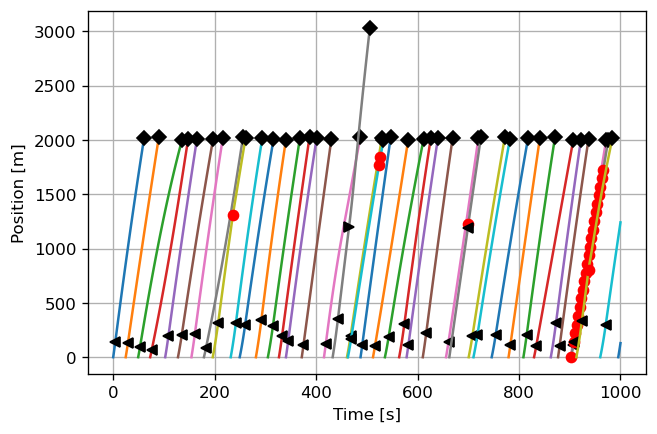

In [104]:
rec.plot('t','x')

# Time Vs Velocity Graph

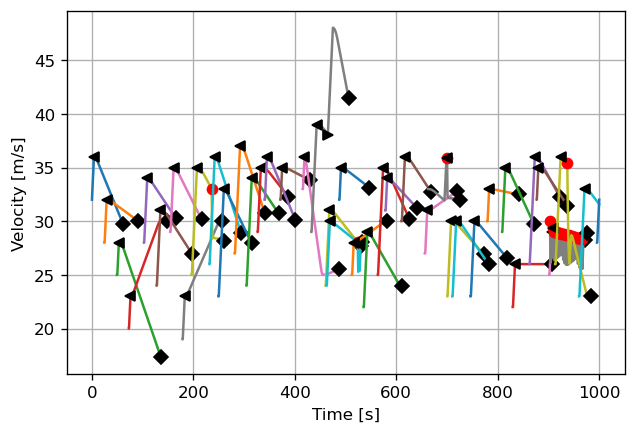

In [105]:
rec.plot('t','v')

# Time vs Acceleration Graph

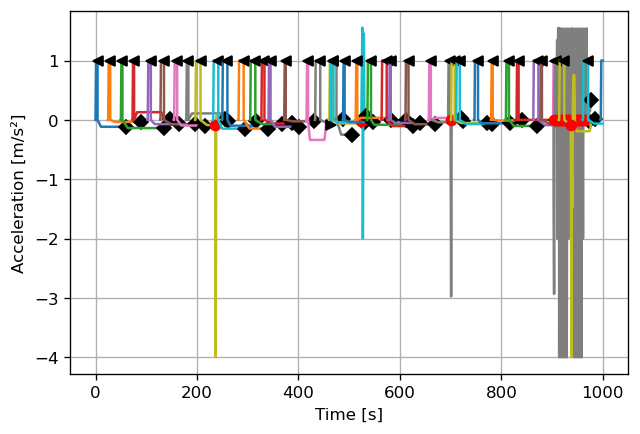

In [106]:
rec.plot('t','a')

# Code Block for Finding Throughput

In [107]:
def throughput():
    last_end_time=rec.getData()[data.event=="end"].iloc[-1]['t']
    start_end_time=rec.getData()[data.event=="end"].iloc[0]['t']
    totalcar_end=len(rec.getData()[data.event=="end"])
    throughput=totalcar_end/((last_end_time-start_end_time)/3600)
    return throughput

In [108]:
throughput_val=throughput()
throughput_val

<ipython-input-107-a7a918249b5f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  last_end_time=rec.getData()[data.event=="end"].iloc[-1]['t']
<ipython-input-107-a7a918249b5f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_end_time=rec.getData()[data.event=="end"].iloc[0]['t']
<ipython-input-107-a7a918249b5f>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  totalcar_end=len(rec.getData()[data.event=="end"])


174.19354838709677

# Code Block for Optimal Traveling Time

In [109]:
def optimaltravellingtime_lst():
    id_car=data.id.unique()
    end_time=[]
    for car in id_car:
        car_data=data[data.id==car]
        start_lane_1=car_data[car_data['event']=="enter lane"]
        end_lane_1=car_data[car_data['event']=="end"]
        if(len(end_lane_1.index)!=0):
            end_time.append(lane_m/(end_lane_1.iloc[-1]['t']-start_lane_1.iloc[0]['t']))
    return end_time

In [110]:
car_data=data[data.id==0]
car_data[car_data['event']=="end"]

,t,x,v,a,id,lane,oldLane,pos,event
112,57,2024.31,34.8716,-0.0262407,0,None,None,2024.31,end


# Optimal Traveling Time

In [88]:
lst=optimaltravellingtime_lst()
optimaltravellingtime=sum(lst) / len(lst)
optimaltravellingtime

52.43448145449667

# Density

In [111]:
density = throughput_val/optimaltravellingtime
density

3.322118261782835